# Fun with Convolution 

The concept of *convolution* is fundamental to understanding modern deep network architectures (indeed, the success of deep convnets in object recognition was arguably the major driver in kickstarting the current wave of AI starting from the early 2010s). 

But convolution can be quite tricky to internalize, particularly when taught from a mathematical viewpoint. This short tutorial is non-mathematical in its treatment, and instead presents a visualization of 2D convolution of an input image with various filters. We will explore both filtering and pooling, both of which are commonly used operations in convnets.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

As visualization examples we will use the MNIST dataset.

In [2]:
ROOT = '.data'
mean = 0.13066 # we use this for normalization
std = 0.30810 # we use this for normalization
test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [mean], std = [std])
                                     ])

test_data = datasets.MNIST(root = ROOT, 
                           train = False, 
                           download = True, 
                           transform = test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



Let us also add some boilerplate code for plotting images.

In [3]:
def plot_filter(images, filtered_images):
    
    n_images = images.shape[0]

    fig = plt.figure(figsize = (20, 5))
    
    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap = 'bone')
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title(f'Output')
        ax.axis('off');

We can now try some basic filtering operations. Let us first grab some images from the test dataset.

In [4]:
num_images = 5
images = []

for i in range(num_images):
  image, label = test_data[i]
  images.append(image)

Let's convert to a Torch tensor by adding a singleton dimension.

In [5]:
images = torch.cat([img.unsqueeze(0) for img in images], dim = 0)


We can now start using these images for illustrating 2D convolution. The `conv2d` function in Torch is perfect for this. 

Convolution, at a high level, takes every small window of input pixels, computes their weighted linear combination (where the weights are the filter values), and produces an output pixel. 

Two key points to note here:
* Each output pixel only depends on a small *local* neighborhood of input pixels.
* The weights of the filter remain the same no matter whether one is computing the first output pixel, or the second, or anywhere in the output (i.e., the filter is *shift-invariant*).

To illustrate: let's start with a small 2x2 filter with all ones. 

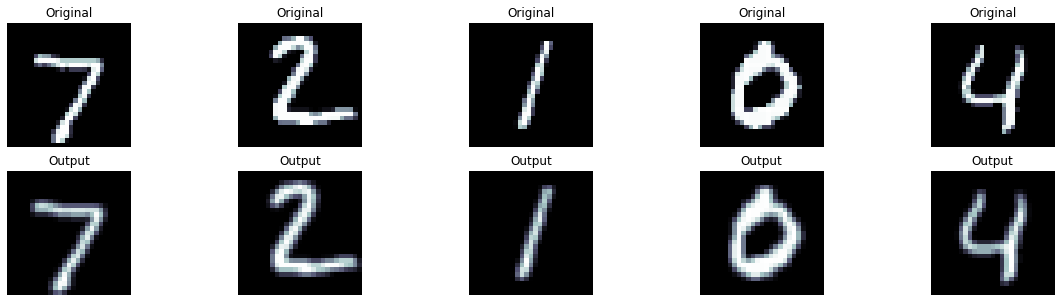

In [6]:
filter = [[1,1],
          [1,1]]
filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0)

filtered_images = F.conv2d(images,filter)
plot_filter(images, filtered_images)


Hmm, can't really see much here (although the outputs look slightly grayer than the inputs). 

Also, if you examine the size of the output, you can see that the size has decreased by 1. (Reason why this is the case by counting the number of possible windows in the input image.)

What if we increase the size of the filter?

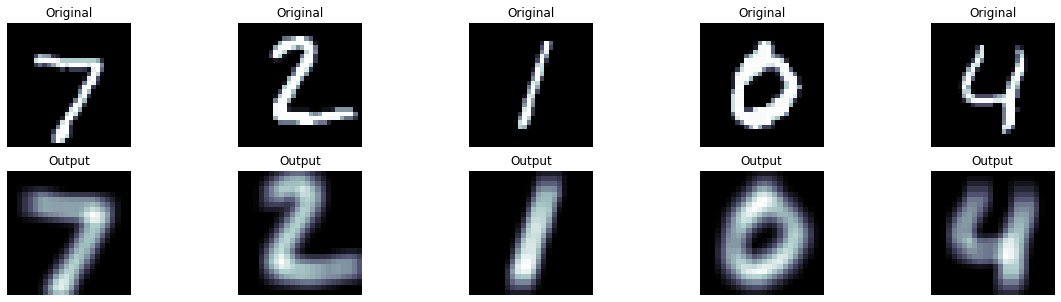

In [7]:
filter = [[1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1],
          [1,1,1,1,1]
          ]
filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0)

filtered_images = F.conv2d(images,filter)
plot_filter(images, filtered_images)

The effect is now much more visible. 

The all-ones filter averages (or smears) out values of the input, therefore producing blurry image outputs. Play around with different filter sizes to see what happens. At what point does the output become completely unrecognizable?


Let us now try an different filter. 

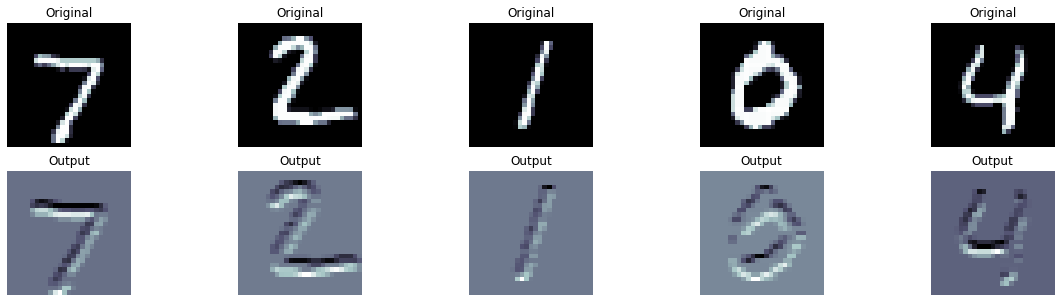

In [8]:
filter = [[1,1],
          [-1,-1]]
filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0)

filtered_images = F.conv2d(images,filter)
plot_filter(images, filtered_images)

Interesting. If you stare carefully, features that are *vertical* (such as most of the 1, or the left side of the 0, or the stalk of the 4) have been grayed out, while features that are *horizontal* (such as the bar of the 7, or the bar of the 4) are bright. This particular filter is a type of *horizontal edge detector*. The effect is slightly more pronounced if we use 3x3 filters.

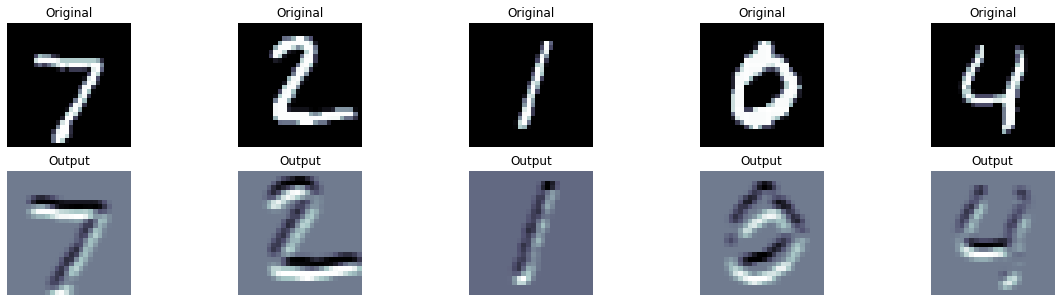

In [9]:
filter = [[1,2,1],
          [0,0,0],
          [-1,-2,-1]]
filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0)

filtered_images = F.conv2d(images,filter)
plot_filter(images, filtered_images)

See if you can get better edge detection using other filters. Play around also with the direction; how would you detect vertical edges?


Let us now also examine pooling. This is related to filtering, and is used to reduce resolution (size) of the input image. Like convolution, this also happens by operating on windows of the input; the difference, however, is that we now use a *stride*, i.e., we skip over certain windows. For example, with stride = 2, we skip computing output of every 2nd window; this means that the output is (approximately, barring fence effects) half the size of the input.

The two most common types of pooling are *average* pooling and *max* pooling.

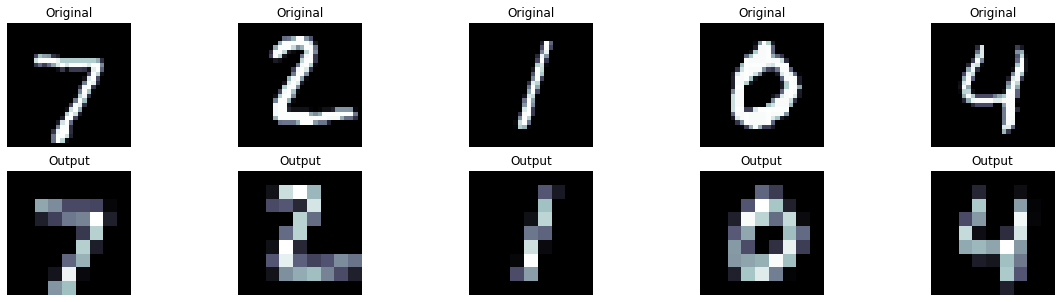

In [10]:
pooled_images = F.avg_pool2d(images,kernel_size=3)
plot_filter(images, pooled_images)

As visually evident, the output looks blocky and very low-res. Also, since we used average pooling here, the output is grayed out. Max-pool retains brightness (since the output is the max of the values in the given window).

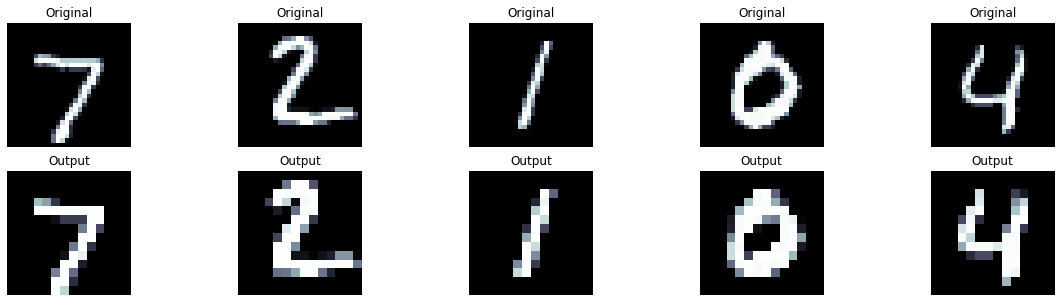

In [11]:
pooled_images = F.max_pool2d(images,kernel_size=2)
plot_filter(images, pooled_images)

This is basically it! We now know what these elementary operations (filtering and pooling) mean in the context of convnets. 

In essence, the forward pass of any convolutional network (however deep) involves some combination of filtering and pooling operations as discussed above, interspersed with nonlinear (pixel-wise) activations, Sometimes possibly other types of pointwise operations such as batch-norm or drop-out are used, but the conv operations are the key.

The crucial difference, of course, is that in convnets, the filter weights are not *a priori* set by hand (as we did in the above examples) but rather incrementally learned from data using back-propagation.